<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_1B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.


# Load libraries

In [4]:
# Scikit-learn (formerly scikits.learn and also known as sklearn) is a free
# software machine learning library for the Python programming language.
# It features various classification, regression and clustering algorithms,
# and is designed to interoperate with the Python numerical and scientific
# libraries NumPy and SciPy. (from wiki)

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [12]:
import os
import tensorflow as tf
import tarfile
import os
from packaging import version
import shutil
import sys

def download_and_extract_data(
    url="https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz",
    target_dir="data",
    fname="colab_material.tgz",
    update_folder=False
):
    """Download and extract a tar.gz dataset into target_dir."""

    if update_folder and os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    if not os.path.exists(target_dir):
        cache_dir = os.path.abspath(".")

        if version.parse(tf.__version__) >= version.parse("2.13.0"):
            # new behavior: fname must be only a filename
            path = tf.keras.utils.get_file(
                fname=fname,
                origin=url,
                cache_dir=cache_dir
            )
        else:
            # old behavior: can pass full path
            path = tf.keras.utils.get_file(
                fname=os.path.join(cache_dir, fname),
                origin=url
            )
        # extract tar into target_dir
        with tarfile.open(path, "r:gz") as tar:
            tar.extractall(target_dir)
    else:
        print('Data already present. Use update_folder = True to overwrite/update if desired.')
    return os.path.abspath(target_dir)

data_path = download_and_extract_data(update_folder=False)
sys.path.append(data_path)
print("Data available at:", data_path)

2256996/2256996 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data available at: /content/data


/tmp/ipython-input-680218323.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(target_dir)


In [ ]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [ ]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

In [ ]:
x, y = get_linear(n_d=1, sigma=1)
plt.plot(x[:, 0], y, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [25]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000, data_path='/content/data'):
  path = os.path.join(data_path, 'data/AmesHousing.csv')

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [26]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


/tmp/ipython-input-3162510123.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


In [15]:
df.describe()

,Order,PID,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2929.000000,2.929000e+03,2929.000000,2439.000000,2929.00000,2929.000000,2929.000000,2929.000000,2929.000000,2906.000000,...,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000
mean,1465.461591,7.143956e+08,57.379652,69.223042,10148.06282,6.095254,5.563332,1971.344486,1984.258791,101.931865,...,93.749744,47.549676,23.019461,2.593377,16.007511,2.244111,50.652441,6.216456,2007.790372,180800.599522
std,846.104363,1.887262e+08,42.643257,23.370001,7881.35958,1.411122,1.111678,30.243747,20.859616,179.133457,...,126.383085,67.489204,64.148601,25.145578,56.096167,35.603235,566.440219,2.714863,1.316832,79899.955086
min,1.000000,5.263011e+08,20.000000,21.000000,1300.00000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.000000,5.284770e+08,20.000000,58.000000,7440.00000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.000000,5.354532e+08,50.000000,68.000000,9434.00000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2198.000000,9.071811e+08,70.000000,80.000000,11556.00000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.000000,1.007100e+09,190.000000,313.000000,215245.00000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [ ]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])

transformation = [[0.4, 0.2], [-0.4, 1.2]]  # affine transformation matrix
x = np.dot(x, transformation)               # applied to point coordinated to make blobs less separable

colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()



## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# 2. Trees & Forests

## 1. Decision Tree

Decision Trees are a supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning **simple** decision rules inferred from the data features.

They are fast to train, easily interpretable, capture non-linear dependencies, and require small amount of data.

We will see that each tree creates a partition of the feature space $X$ into subregions $R_i,i=1..N_r$, this partition being described by a tree structure. Predictions will be made with the following procedure. Given a new test point $x$:

1. Assign $x$ to the region it belongs, e.g. $R_k$
2. For classification, make a majiority vote using the training points belonging to $R_k$. For regression, evaluate the mean of the target over all training points belonging to $R_k$.

Let's see how the trees generate a partition of the domain into distinct regions.


training score : 0.667 (depth=1)


NameError: name 'plot_prediction_2d' is not defined

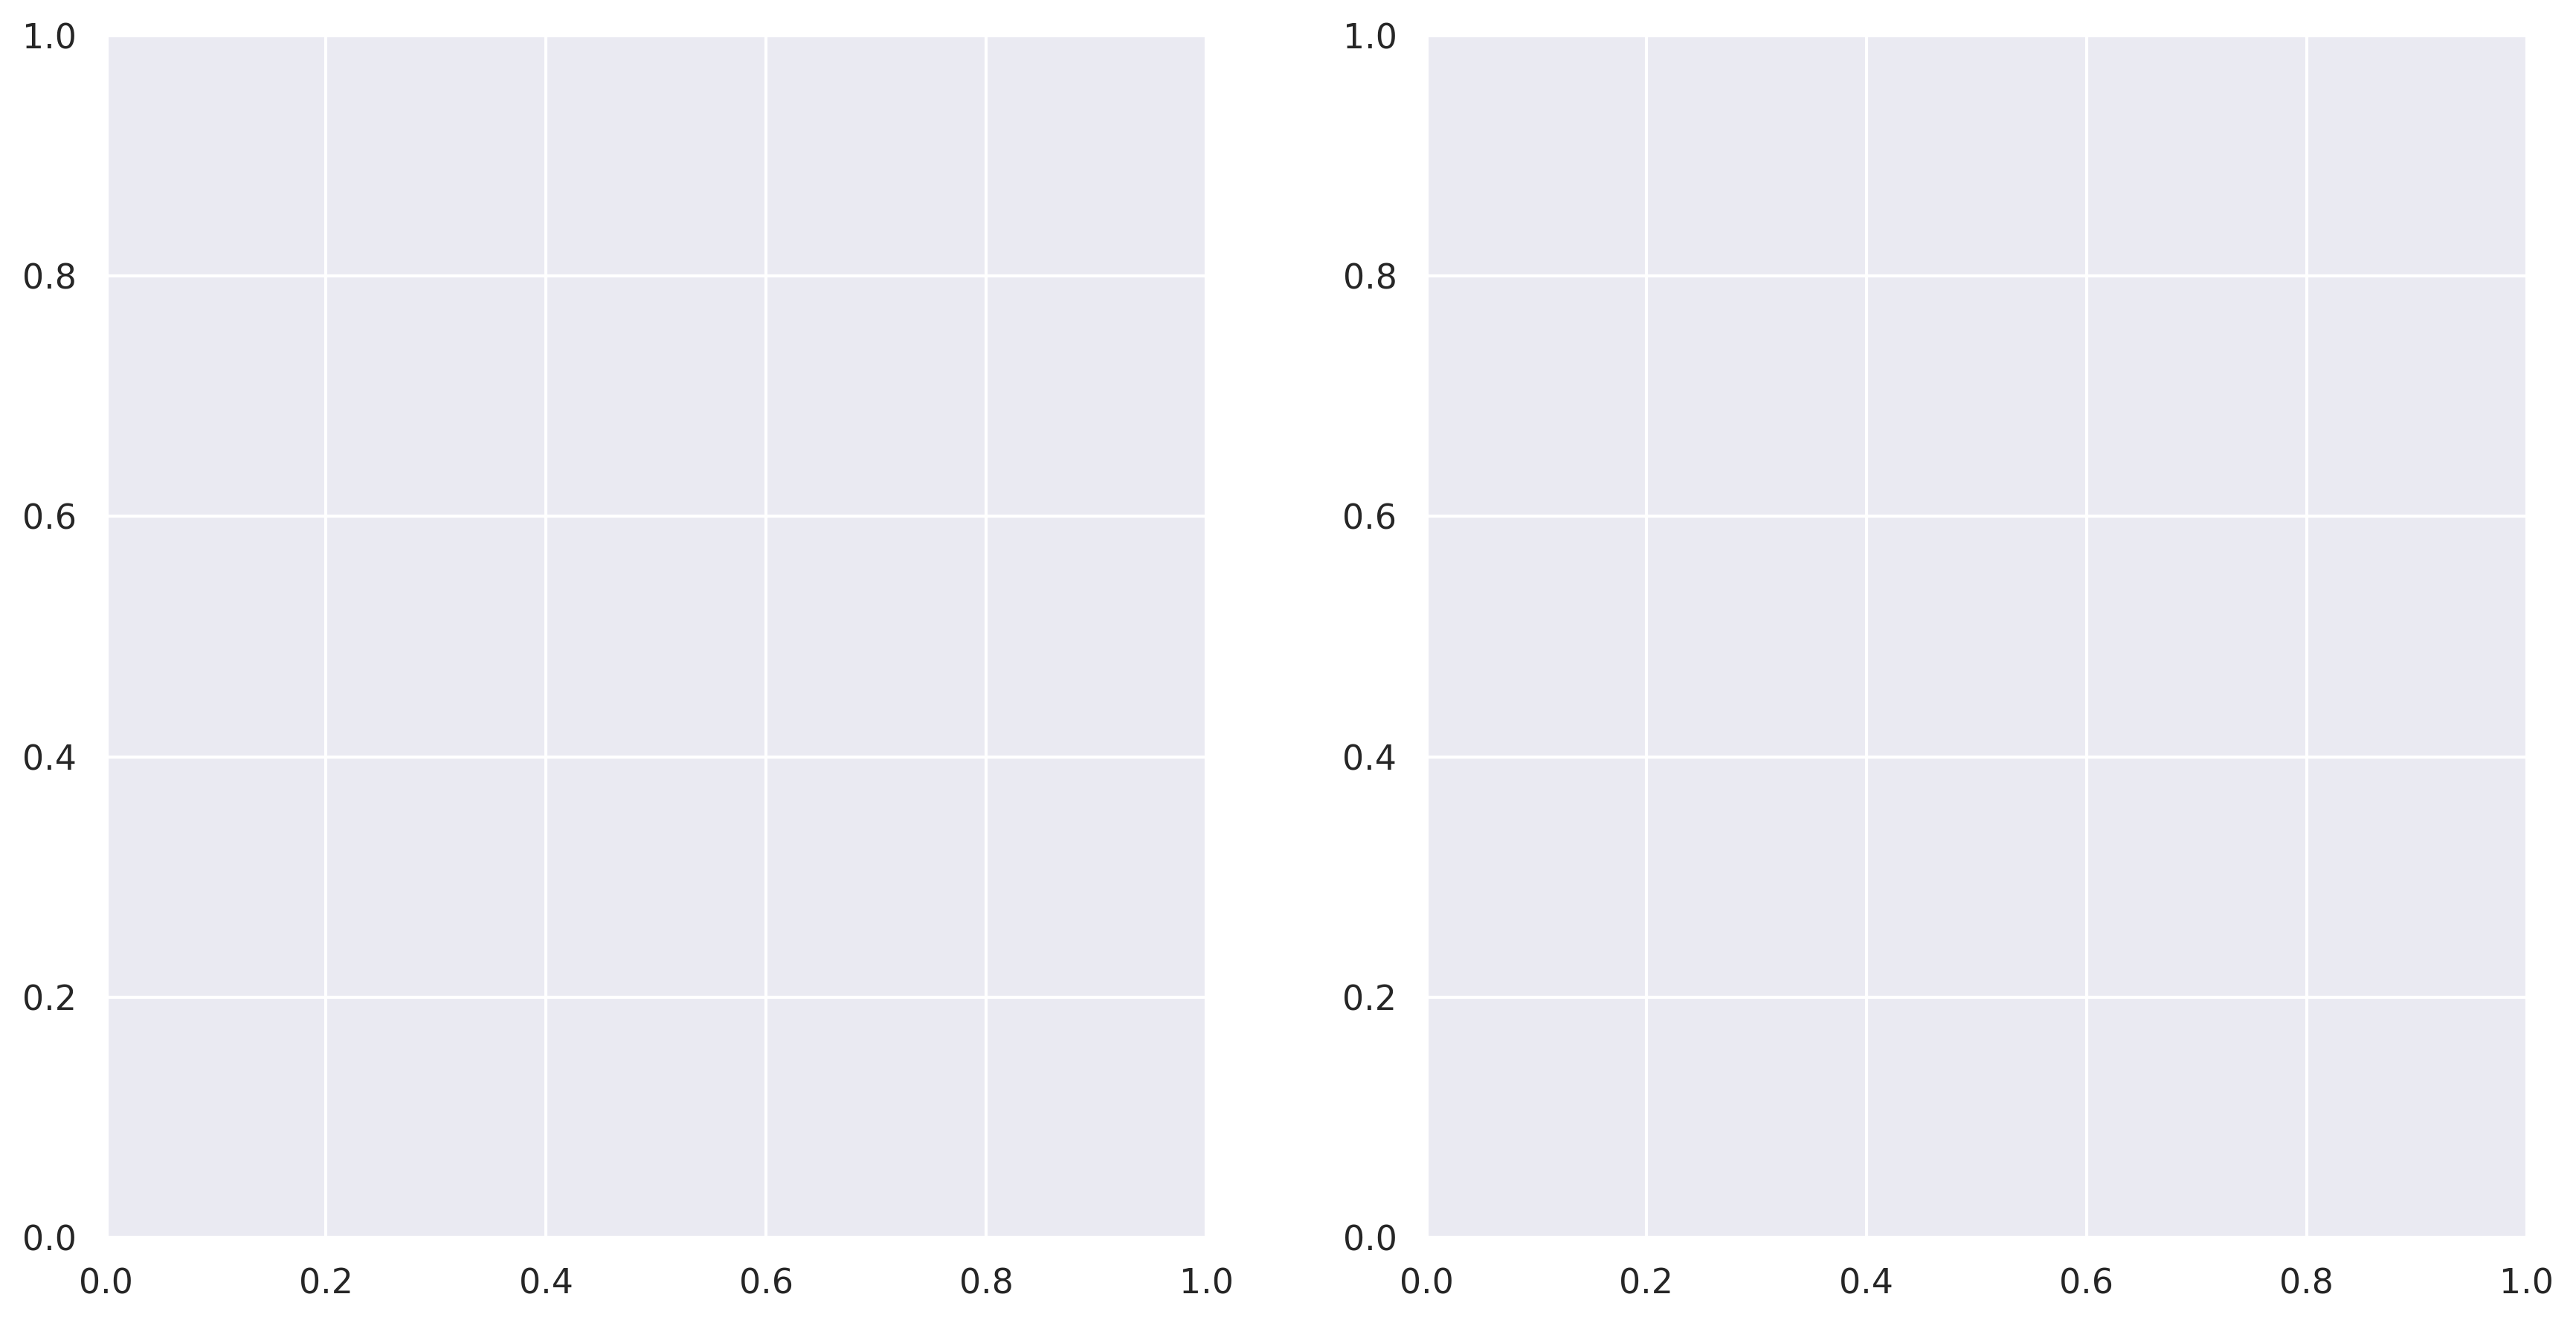

In [7]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)
dtcs = []
for depth in (1, 2, 3, 4):
    # do fit
    dtc = tree.DecisionTreeClassifier(max_depth=depth, criterion='gini', min_samples_leaf=3)  # 'entropy'
    dtcs.append(dtc)
    dtc.fit(X, y)

    # print the training scores
    print("training score : %.3f (depth=%d)" % (dtc.score(X, y), depth))

    # get range for visualization
    x_0 = X[:, 0]
    x_1 = X[:, 1]
    x_min = x_0.min() - 1
    x_max = x_0.max() + 1
    y_min = x_1.min() - 1
    y_max = x_1.max() + 1

    fig, ax = plt.subplots(1, 2,  figsize=(14,7), dpi=300)
    plot_prediction_2d(x_min, x_max, y_min, y_max, classifier=dtc, ax=ax[0])

    ax[0].set_title("Decision surface of DTC (%d)" % depth)

    # Plot also the training points
    colors = "rbg"
    for i, color in zip(dtc.classes_, colors):
        idx = np.where(y == i)
        ax[0].scatter(x_0[idx], x_1[idx], c=color,
                    edgecolor='black', s=20, linewidth=0.2)

    with plt.style.context('classic'):
      tree.plot_tree(dtc, ax=ax[1]);

    plt.tight_layout()
    plt.show()

## How is the tree constructed from a labelled training set?

We distinguish two cases: **classification** and **regression**.

---
### Classification
Given a sample $S$ of $N$ points in feature space ($x_i$, $i=1...N$), each assigned to one of $C$ classes ($c_i \in \{1,..,C\}$), we compute class proportions:
$$p_c = \frac{N_c}{N}$$
where $N_c$ is the number of points in class $c$.

**Impurity measures:**
- **Gini index:**
  $$G(S) = 1 - \sum_c p_c^2$$
- **Entropy:**
  $$E(S) = -\sum_c p_c \log(p_c)$$

These quantify how mixed the classes are in a node.

**Splitting:**
- At each step, choose a feature and cutoff $a$.
- Points with $x_{i,k} < a$ go left; $x_{i,k} \ge a$ go right.
- Define $S_{<}$, $S_{>}$ and their sizes $N_{<}$, $N_{>}$.
- **Information gain:**
  $$ IG = E(S) - \frac{N_{<}}{N} E(S_{<}) - \frac{N_{>}}{N} E(S_{>}) $$
- (Same formula for Gini index.)
- The split with highest information gain is chosen, favoring relevant features at the top and helping reduce overfitting by pruning.

---
### Regression
Similar setup, but targets are real values $y_i \in \mathbb{R}$.

**Splitting criterion:**
- Use sample variance:
  $$V(S) = \frac{1}{N} \sum_i (y_i - \bar{y})^2$$
- After splitting, compute means $y_{<}$ and $y_{>}$ for left/right nodes.
- **Reduction in variance:**
  $$ \frac{N_{<}}{N} V(S_{<}) + \frac{N_{>}}{N} V(S_{>}) = \frac{1}{N}\left(\sum_{i \in S_{<}} (y_i-y_{<})^2 + \sum_{i \in S_{>}} (y_i-y_{>})^2\right) $$
- The best split maximizes reduction in variance.

---
These are known as the **CART** (Classification and Regression Trees) splitting criteria.

## 2. Random Forest

The `sklearn.ensemble` provides several ensemble algorithms. RandomForest is an averaging algorithm based on randomized decision trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction.

The prediction of the ensemble is given as the averaged prediction of the individual classifiers (regression) or by majority voting (classification). E.g. for regression:

$$ RF(x) = \frac{1}{N_\text{trees}}\sum_{i=1}^{N_\text{trees}} Tree_i(x)$$

Individual decision trees typically exhibit high variance and tend to overfit.
In random forests:
* each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.
* when splitting each node during the construction of a tree, the best split is found from a random subset of features, according to `max_features` parameter.

The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant, hence yielding an overall better model.


training score : 0.960 (n_est=1)


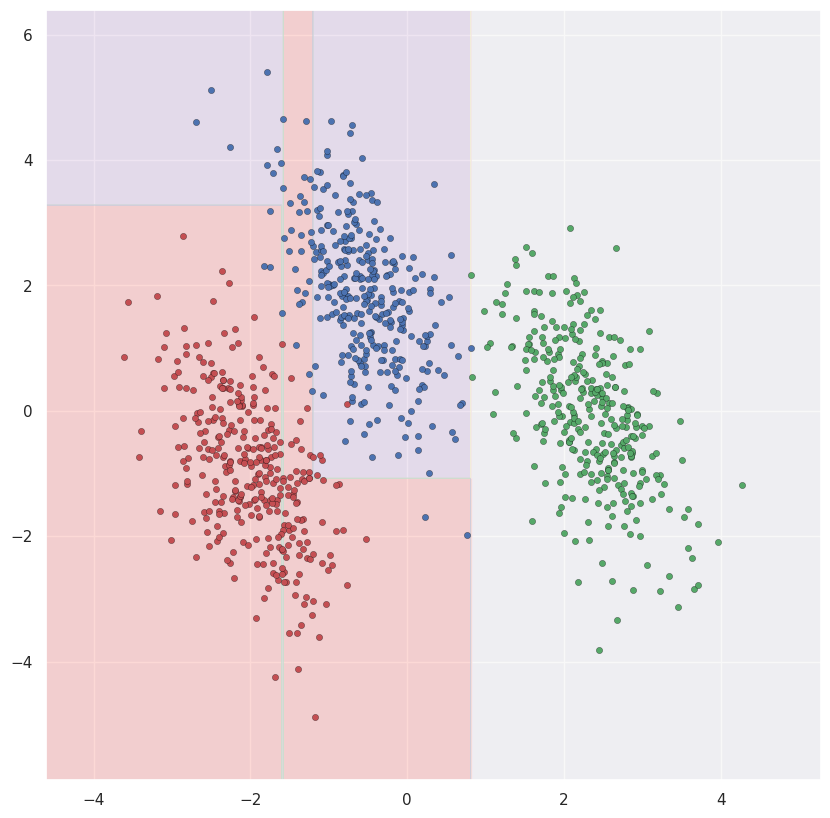

training score : 0.976 (n_est=4)


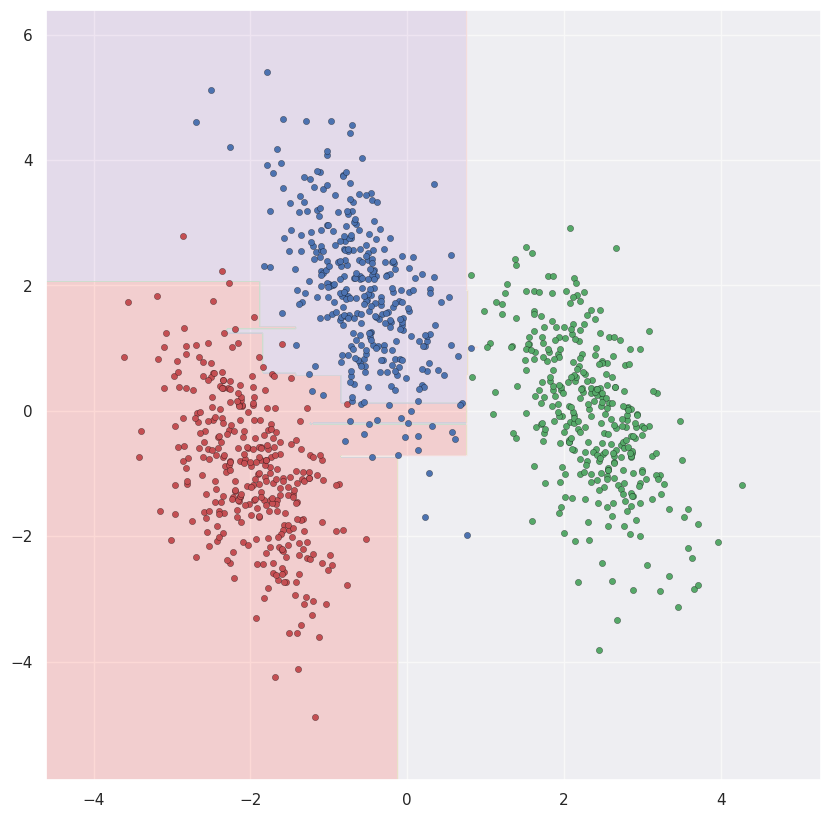

training score : 0.997 (n_est=50)


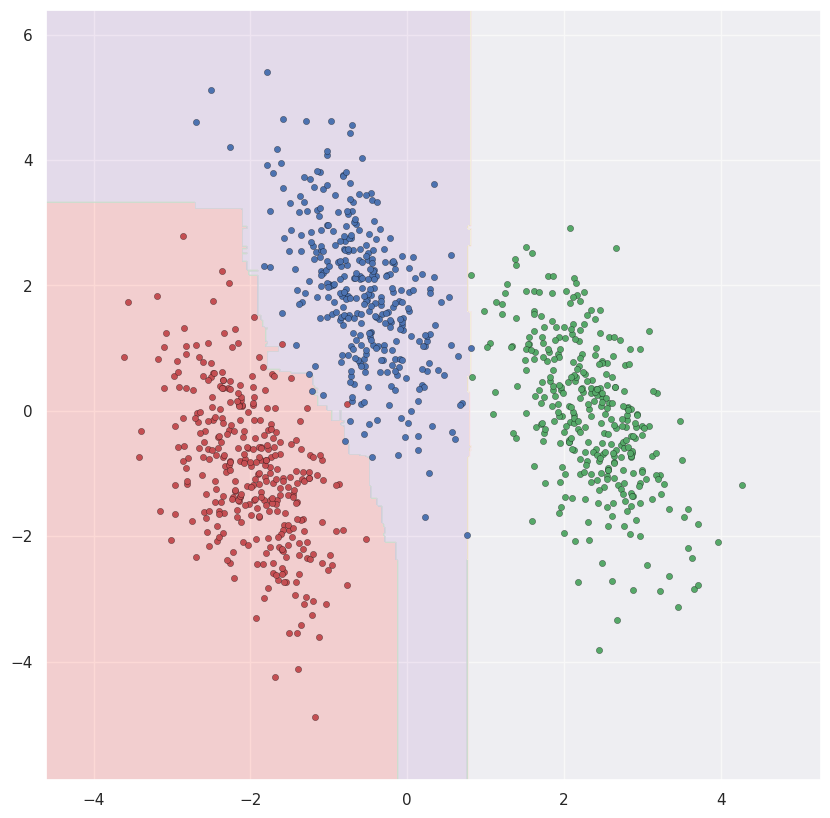

In [ ]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for n_est in (1, 4, 50):
    # do fit
    rfc = ensemble.RandomForestClassifier(max_depth=4, n_estimators=n_est,)
    rfc.fit(X, y)

    # print the training scores
    print("training score : %.3f (n_est=%d)" % (rfc.score(X, y), n_est))

    # get range for visualization
    x_0 = X[:, 0]
    x_1 = X[:, 1]
    x_min = x_0.min() - 1
    x_max = x_0.max() + 1
    y_min = x_1.min() - 1
    y_max = x_1.max() + 1

    plt.figure(figsize=(10,10))
    plot_prediction_2d(x_min, x_max, y_min, y_max, classifier=rfc)

    # Plot also the training points
    colors = 'rbg'
    for i, color in enumerate(colors):
        idx = np.where(y == i)
        plt.scatter(x_0[idx], x_1[idx], c=color,
                    edgecolor='black', s=20, linewidth=0.2)


    plt.show()

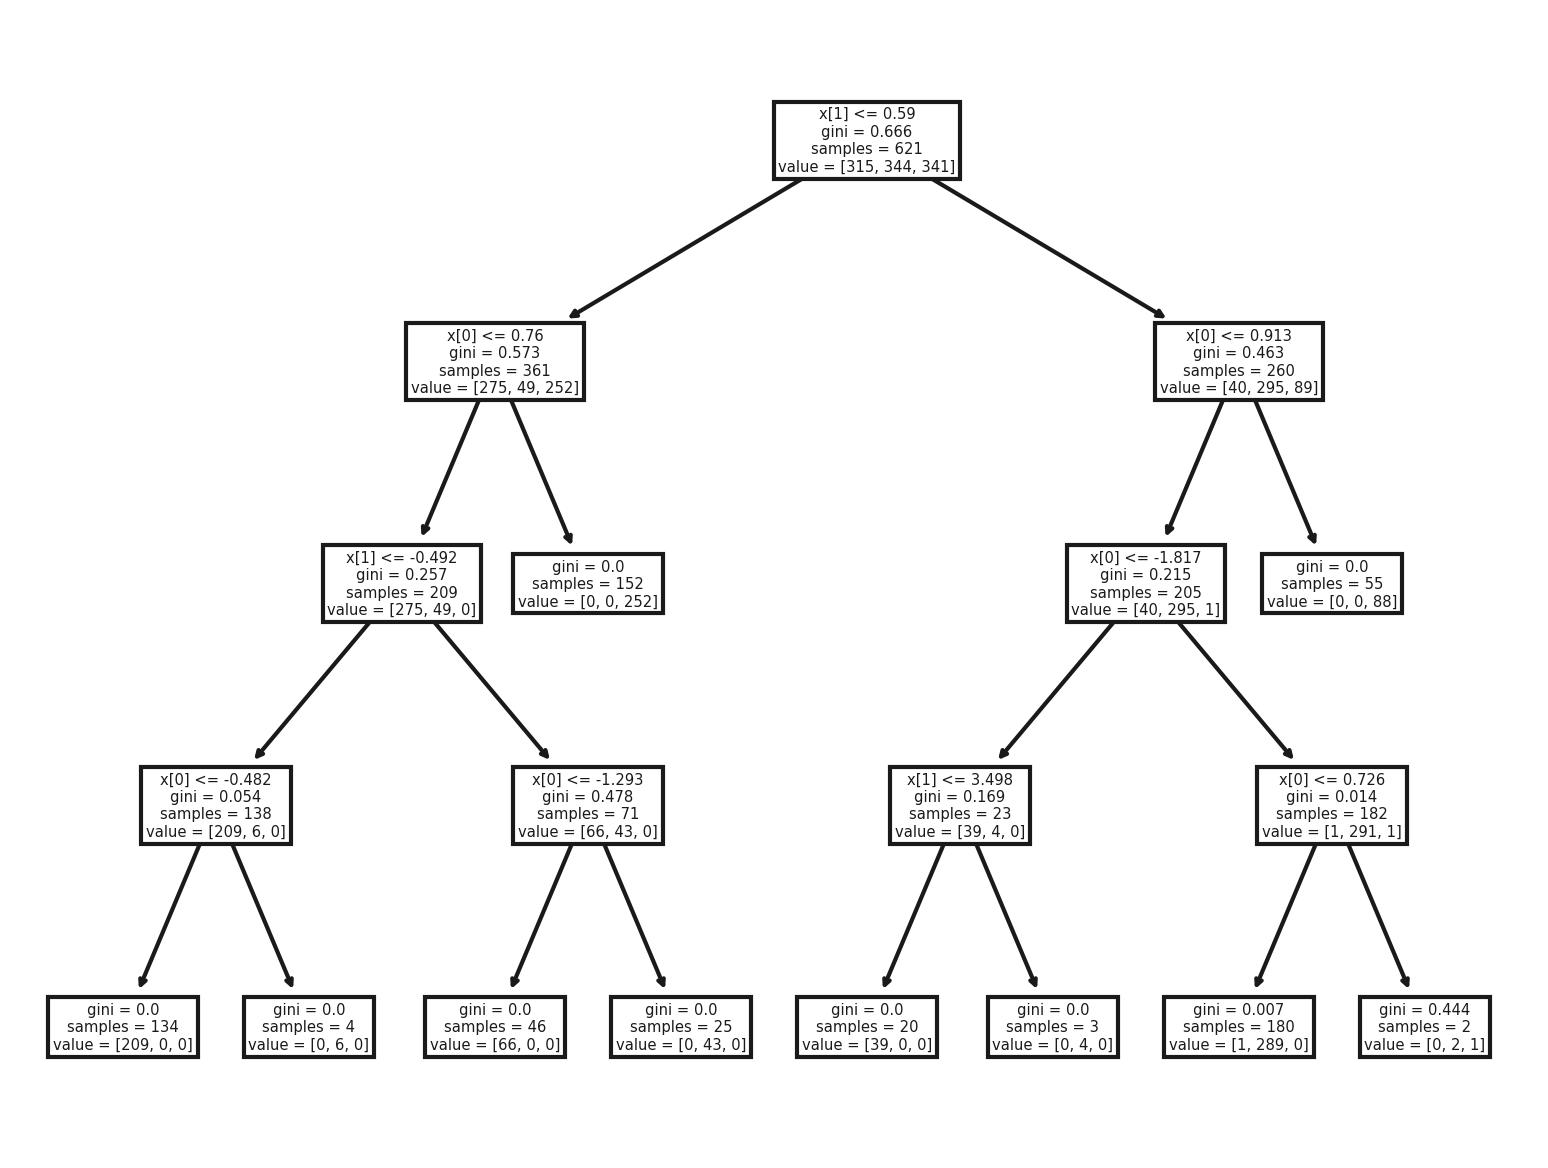

In [ ]:
plt.figure(dpi=300)
with plt.style.context('classic'):
  tree.plot_tree(rfc.estimators_[20]);

## 3. Boosted Decision Trees (XGboost)

Another approach to the ensemble tree modeling is Boosted Decision Trees. In a boosting framework, the trees are created sequentially. This way each next tree reduces error of the ensemble, by adding corrections to previous predictions.

Corrections to the predictions of boosted decision trees are sequentially added, in contrast with random forest predictions:

$$ Boost(x) = Tree_0(x)+\lambda \sum_{i=1}^{N_\text{trees}} Tree_i(x)$$

Notes:

- The trees used at each step are very shallow trees (with high biased). Boosting is a way to combine `weak` classifiers (high bias, low variance) and decrease bias and increase variance gradually, in a controlled way.

- $\lambda$ is a parameters, called shrinkage or learning rate, that describes how fast we are changing the predictions at each step. A smaller learning rate is useful to control overfitting.

- Predictions and classifications are treated often on the same footing, by making the ensemble output logits.



One of the most popular implementations of boosting is XGBoost:

https://arxiv.org/abs/1603.02754

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [6]:
from xgboost import XGBClassifier

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

params = {
    'num_class': 3,               # Number of classes in the target variable
    'max_depth': 3,               # Maximum depth of trees
    'learning_rate': 0.1,         # Learning rate
    'n_estimators': 100
}
model = XGBClassifier(**params)
model.fit(X, y, verbose=True)

# print the training scores
#print("training score : %.3f (n_est=%d)" % (dtc.score(X, y), n_est))
x_0 = X[:, 0]
x_1 = X[:, 1]
x_min = x_0.min() - 1
x_max = x_0.max() + 1
y_min = x_1.min() - 1
y_max = x_1.max() + 1
plt.figure(figsize=(10,10))
plot_prediction_2d(x_min, x_max, y_min, y_max, classifier = model)

plt.title(f'Decision surface of Boosted model after 100 iterations')
plt.axis('tight')

# Plot also the training points
colors = 'rbg'
for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(x_0[idx], x_1[idx], c=color,
                edgecolor='black', s=20, linewidth=0.2)

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()


plt.show()

NameError: name 'plot_prediction_2d' is not defined

<Figure size 1000x1000 with 0 Axes>

In [17]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

x, y = house_prices_dataset()

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

evals_result = {}
# Create an XGBoost regression model
model = XGBRegressor(eval_metric='rmse' ,
                     max_depth = 5,
                     early_stopping_rounds = 10,
                     learning_rate = 0.3,
                     n_estimators = 1000 )

# Train the XGBoost regression model
model.fit(x_train, y_train,
          eval_set=[(x_train, y_train),(x_test, y_test)],
          verbose=True)

y_p_train = model.predict(x_train)
y_p_test = model.predict(x_test)

[0]	validation_0-rmse:50357.44157	validation_1-rmse:51163.35592
[1]	validation_0-rmse:39806.43900	validation_1-rmse:41084.34513
[2]	validation_0-rmse:32540.19653	validation_1-rmse:34238.98438
[3]	validation_0-rmse:27687.90246	validation_1-rmse:29893.50347
[4]	validation_0-rmse:24251.65356	validation_1-rmse:26767.50580
[5]	validation_0-rmse:22084.04103	validation_1-rmse:24983.04957
[6]	validation_0-rmse:20521.50453	validation_1-rmse:23783.04626
[7]	validation_0-rmse:19486.87020	validation_1-rmse:23264.03942
[8]	validation_0-rmse:18660.54678	validation_1-rmse:22582.99182
[9]	validation_0-rmse:18013.66758	validation_1-rmse:22140.61031
[10]	validation_0-rmse:17572.91201	validation_1-rmse:21929.69641
[11]	validation_0-rmse:17179.17288	validation_1-rmse:21817.98197
[12]	validation_0-rmse:16876.49737	validation_1-rmse:21759.07703
[13]	validation_0-rmse:16595.70261	validation_1-rmse:21618.96121
[14]	validation_0-rmse:16357.56623	validation_1-rmse:21603.84189
[15]	validation_0-rmse:16155.68564	

/tmp/ipython-input-3162510123.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


[24]	validation_0-rmse:14517.34580	validation_1-rmse:21217.86894
[25]	validation_0-rmse:14419.84482	validation_1-rmse:21291.19836
[26]	validation_0-rmse:14136.86178	validation_1-rmse:21258.66275
[27]	validation_0-rmse:13990.10579	validation_1-rmse:21263.14593
[28]	validation_0-rmse:13906.32311	validation_1-rmse:21216.18361
[29]	validation_0-rmse:13722.73484	validation_1-rmse:21216.95161
[30]	validation_0-rmse:13636.70502	validation_1-rmse:21211.42586
[31]	validation_0-rmse:13376.20749	validation_1-rmse:21415.79803
[32]	validation_0-rmse:13105.81317	validation_1-rmse:21475.69228
[33]	validation_0-rmse:12875.29335	validation_1-rmse:21531.77983
[34]	validation_0-rmse:12762.61498	validation_1-rmse:21470.01632
[35]	validation_0-rmse:12705.12099	validation_1-rmse:21466.71364
[36]	validation_0-rmse:12643.55106	validation_1-rmse:21460.47590
[37]	validation_0-rmse:12614.98386	validation_1-rmse:21453.07795
[38]	validation_0-rmse:12579.94929	validation_1-rmse:21453.26600
[39]	validation_0-rmse:12

In [ ]:
plt.plot(model.evals_result_['validation_0']['rmse'], label='train')
plt.plot(model.evals_result_['validation_1']['rmse'], label='test')
plt.legend()
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.show()

In [ ]:
from sklearn.metrics import r2_score

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))

residuals=y_train - y_p_train
print('train mse =', np.sqrt( np.mean(residuals**2)) )
residuals=y_test - y_p_test
print('train mse =', np.sqrt( np.mean(residuals**2)) )

# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', r2_score(y_train, y_p_train))
print('test R2 =', r2_score(y_test, y_p_test))


# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot(y_train, y_train,'-')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

## EXERCISE 3 : Random forest for FMNIST

Classify fashion MNIST images with Random Forest classifier. This is similar to Ex 2 (Logistic Regression for FMNIST) but you have to play with a different classifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Repeat the steps of Ex. 2, but in step 3 when fitting the model, you can play with r.f. parameters.

# TIP:  You can use verbose = 2 to see the training progress (in case it is too slow) and n_jobs=-1 to use all available corse: ensemble.RandomForestClassifier(..., verbose=2, n_jobs=-1)

Once you are done, call clf.get_params() and update the google doc here with your findindgs!

https://docs.google.com/document/d/1f5sDOS_cq1_ZaUkwlSnog5I8jpYiK_QAF1hk3vcBFL8/edit?usp=sharing

# Interpretable Machine Learning: Feature Importance

Understanding how a model makes decisions is a key aspect of **Interpretable Machine Learning**. This is crucial for:

* debugging
* model development
* building trust in predictions
* generalizability

Many methods produce a feature importance plot. The simplest approach is **Permutation Feature Importance** ([scikit-learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html)):

---

### Permutation Feature Importance: Methodology

1. **Train Model**
    - Fit the model on training data and compute the `baseline_score`.
2. **For each feature `f`:**
    - Shuffle `f` in the validation data.
    - Compute the `shuffled_score` using the trained model.
    - Calculate `importances[f] = baseline_score - shuffled_score`.
3. **(Optional) Normalization**
    - Normalize the `importances` vector so all values are positive and sum to one.

---

For **Random Forest** models, another type of feature importance is available as a model attribute. This method is much faster to plot than permutation feature importance.

## Feature Importance in Practice

Below is a code snippet demonstrating how to compute and compare permutation feature importance and Random Forest feature importance for Exercise 3 (see Solutions for full code):

```python
# Permutation Feature Importance
from sklearn.inspection import permutation_importance
p_importances = permutation_importance(
    clf, test_features, test_labels, n_repeats=10, n_jobs=-1
)

# Random Forest Feature Importance
rf_importances = clf.feature_importances_
```

- `p_importances`: Measures the decrease in model score when a feature is randomly shuffled, indicating its impact on predictions.
- `rf_importances`: Directly provided by the Random Forest model, reflecting the average decrease in impurity across all trees for each feature.

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/FMNIST_feature_importance.png" width="80%"/>
<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/FMNIST_feature_importance_2.png" width="80%"/>

LIMITATIONS:

1.  The samples generated may be out-of-distribution, therefore uninteresting or belonging to a region where the model returns random values
2.  In the presence of correlated features a model can rely on one or the other feature for prediction. This may lead to misleading interpetations.

PARTIAL SOLUTION: perform a study of the correlation between the variables to interpret the validation plot.





FURTHER READINGS (advanced):

1. "Why Should I Trust You?": Explaining the Predictions of Any Classifier, https://arxiv.org/abs/1602.04938
2. "Explaining individual predictions when features are dependent: More accurate approximations to Shapley values", https://arxiv.org/abs/1903.10464
3. https://shap.readthedocs.io/en/latest/overviews.html

## EXERCISE 4: Random forest for AMES with Feature Imporance


In [16]:
X, y, (df_x, df_y) = house_prices_dataset(return_df_xy=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/tmp/ipython-input-3162510123.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical


Predict the house prices using either a RandomForest model or boosted tree (choose one). Suggestion:

```python
model = ensemble.RandomForestRegressor(max_depth=... n_estimators= ...)
```

Use permutation importance for the feature importance.

In [18]:
# 1. Review the examples showcasing the usage of the random forest model or xgboost.

# 2. Fit the model

# 3. Inspect training and test accuracy

# 4. Try to improve performance by adjusting hyperparameters.
# How does it compare to linear model? Can you make a plot of y_pred vs y_exact as you did for a linear model and compare visually ?

# 5. Study the feature importance


# Helper code for plotting the permutation feature importances in this dataset:
def plot_importances(feature_names, permutation_importances):
        """
        Plots horizontal bar chart of permutation feature importances.

        Parameters
        ----------
        feature_names : list or array-like
                Names of the features corresponding to the importances.
        permutation_importances :
                Output from sklearn.inspection.permutation_importance, containing
                importances_mean and importances_std for each feature.

        Returns
        -------
        None
                Displays the plot.
        """
        plt.figure(figsize=(8, 10))
        plt.barh(feature_names,
                        permutation_importances.importances_mean,
                        yerr=permutation_importances.importances_std, )
        plt.ylabel('feature')
        plt.xlabel('importance')
        plt.xlim(0, 1)
        return

# Task
Demonstrate the usage of the random forest model for regression using the house prices dataset.

## Load and prepare the data

### Subtask:
Load the house prices dataset and split it into training and testing sets.


## Train a random forest regressor model

### Subtask:
Initialize and train a `RandomForestRegressor` model on the training data.


**Reasoning**:
Initialize and train a RandomForestRegressor model on the training data.



In [33]:
model = ensemble.RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

## Evaluate the model

### Subtask:
Calculate and print evaluation metrics (e.g., R2 score, Mean Absolute Error) for both the training and testing sets.


**Reasoning**:
Calculate and print the evaluation metrics for the trained model on both training and testing sets.



In [34]:
from sklearn.metrics import r2_score, mean_absolute_error

y_p_train = model.predict(x_train)
y_p_test = model.predict(x_test)

train_r2 = r2_score(y_train, y_p_train)
test_r2 = r2_score(y_test, y_p_test)

train_mae = mean_absolute_error(y_train, y_p_train)
test_mae = mean_absolute_error(y_test, y_p_test)

print(f'Train R2 Score: {train_r2:.4f}')
print(f'Test R2 Score: {test_r2:.4f}')
print(f'Train Mean Absolute Error: {train_mae:.2f}')
print(f'Test Mean Absolute Error: {test_mae:.2f}')

Train R2 Score: 0.9657
Test R2 Score: 0.8887
Train Mean Absolute Error: 9246.95
Test Mean Absolute Error: 14798.37


## Visualize predictions

### Subtask:
Plot the true house prices against the predicted house prices for both the training and testing sets to visually assess the model's performance.


**Reasoning**:
Plot the true values against the predicted values for both training and testing sets to visually assess the model's performance, including a reference line and appropriate labels and aspect ratio.



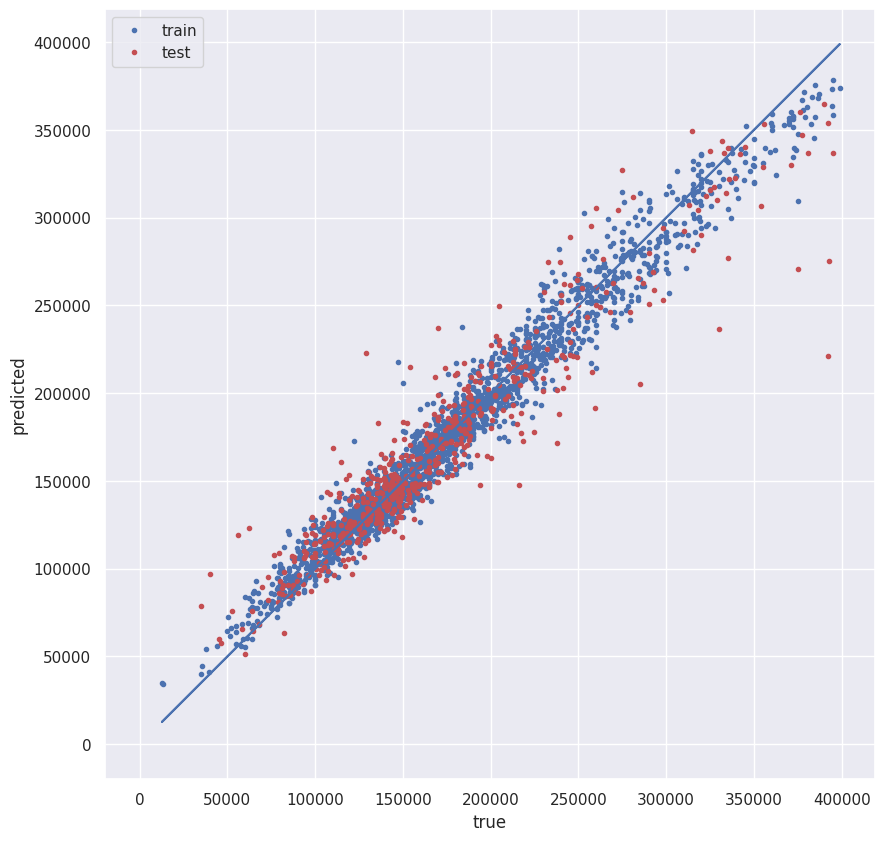

In [35]:
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train, y_train,'-')
plt.plot([0], [0], 'w.', markersize=0)
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

## Calculate permutation feature importance

### Subtask:
Compute the permutation feature importance for the trained model on the test set.


**Reasoning**:
Compute the permutation feature importance for the trained model on the test set as requested in the subtask instructions.



In [36]:
p_importances = permutation_importance(
    model, x_test, y_test, n_repeats=10, n_jobs=-1, random_state=42
)

**Reasoning**:
Sort the feature importances and plot them as a horizontal bar chart using the provided helper function to visualize the most important features.



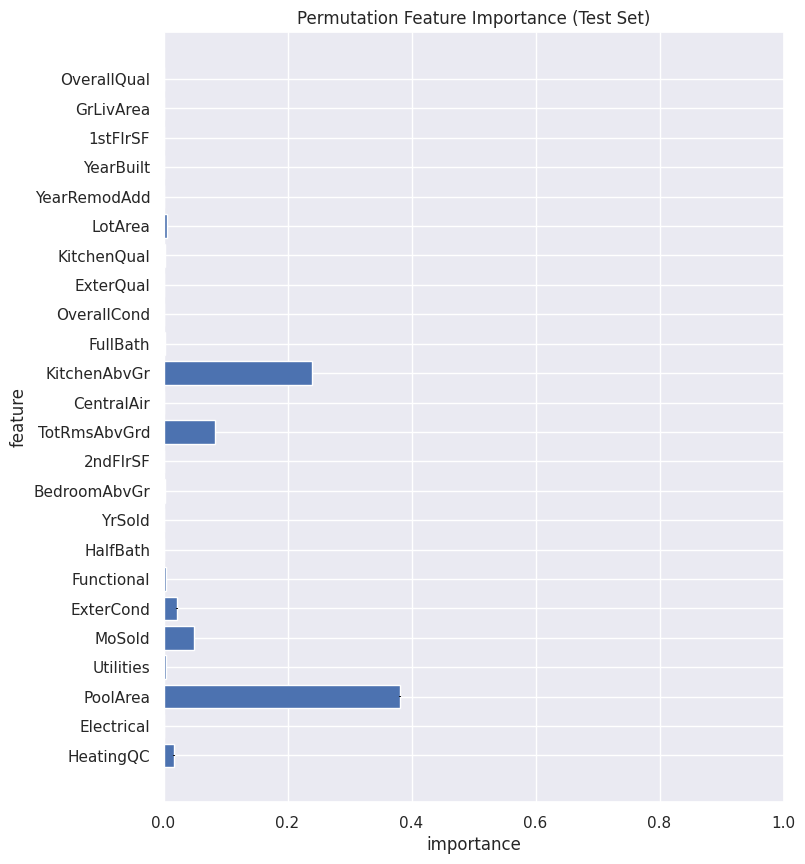

In [37]:
#sorted_idx = p_importances.importances_mean.argsort()
#feature_names = df_x.columns[sorted_idx]

plot_importances(feature_names, p_importances)
plt.title('Permutation Feature Importance (Test Set)')
plt.show()

Note 2025-09: Split Train-Test is OK here, if tuning of hyperparameters is done, an additional validations et is used (Train-Val-Test), to optimize performance depending on hyperparameters on val, and then finally assess on test